Carga en b1a: P = 30.0 MW, Q = 20.0 MVA
Carga en b2a: P = 52.5 MW, Q = 35.0 MVA
Carga en b3a: P = 22.5 MW, Q = 15.0 MVA
Carga en b2b: P = 90.0 MW, Q = 60.0 MVA
Carga en b1b: P = 15.0 MW, Q = 10.0 MVA
      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -212.310191   5.807279
1  1.033380 -14.276471    0.000000   0.000000
2  1.031457 -14.492303   30.000000  20.000000
3  1.029237 -14.730336   52.500000  35.000000
4  1.028365 -14.864945   22.500000  15.000000
5  1.032375 -14.469768   15.000000  10.000000
6  1.027435 -14.873522   90.000000  60.000000


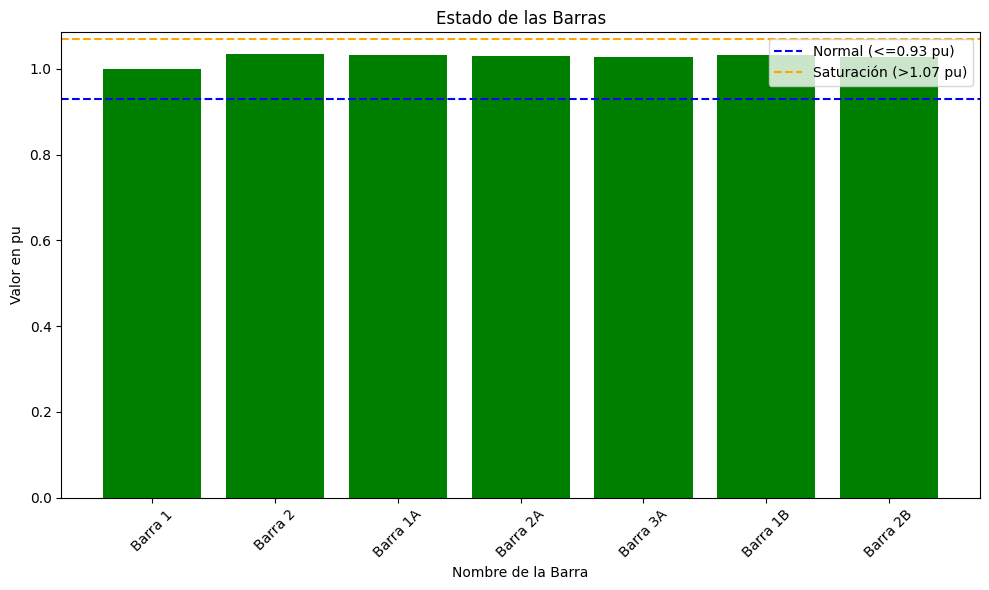

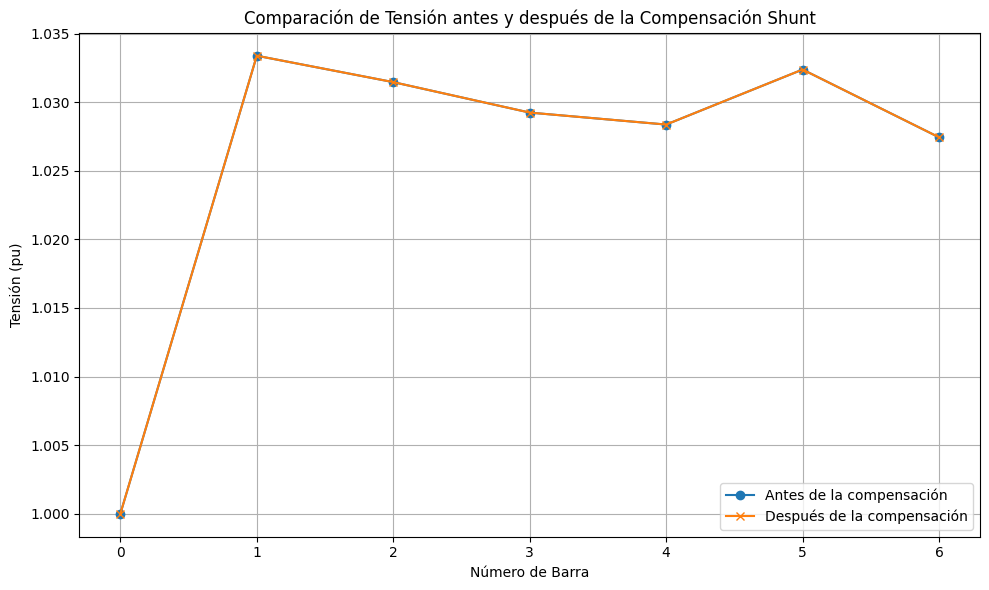

Línea entre B2B y B3A no encontrada.
La línea entre B2B y B3A está conectada.


In [3]:
import numpy
import scipy
import numba
import matplotlib.pyplot as plt
import pandapower as pp
import pandapower.networks
import pandapower.topology
import pandapower.plotting as pplot
import pandapower.converter
import pandapower.estimation
import os
import matplotlib.pyplot as plt

# Creación red vacía
net = pp.create_empty_network()



# Crear barras
b1 = pp.create_bus(net, vn_kv=110, name="Barra 1")
b2 = pp.create_bus(net, vn_kv=220, name="Barra 2")
b1a = pp.create_bus(net, vn_kv=220, name="Barra 1A")
b2a = pp.create_bus(net, vn_kv=220, name="Barra 2A")
b3a = pp.create_bus(net, vn_kv=220, name="Barra 3A")
b1b = pp.create_bus(net, vn_kv=220, name="Barra 1B")
b2b = pp.create_bus(net, vn_kv=220, name="Barra 2B")

pp.create_ext_grid(net, bus=b1, vm_pu=1, name="Conexion de malla")
# Creacion transformador usando un modelo predefinido
pp.create_transformer(net, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV")
# Define un tipo de línea aproximado para "N2XS(FL)2Y 1x185 RM/35 64/110 kV"



# Creación de líneas entre barras
pp.create_line(net, from_bus=b2, to_bus=b1a, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea B2-B1A")
pp.create_line(net, from_bus=b2, to_bus=b1b, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea B2-B1B")
pp.create_line(net, from_bus=b1a, to_bus=b2a, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea B1A-B2A")
pp.create_line(net, from_bus=b2a, to_bus=b3a, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea B2A-B3A")
pp.create_line(net, from_bus=b3a, to_bus=b2b, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea B3A-B2B")
pp.create_line(net, from_bus=b2b, to_bus=b1b, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea B2B-B1B")

# Valores nominales de carga
P_nominal_MW = 150
Q_nominal_MVA = 100

# Crear un diccionario que mapee los nombres de las barras que tienen carga
bus_dict = {
    "b1a": pp.get_element_index(net, "bus", "Barra 1A"),
    "b2a": pp.get_element_index(net, "bus", "Barra 2A"),
    "b3a": pp.get_element_index(net, "bus", "Barra 3A"),
    "b2b": pp.get_element_index(net, "bus", "Barra 2B"),
    "b1b": pp.get_element_index(net, "bus", "Barra 1B"),
}

# Porcentajes de carga para cada barra
cargas = {
    "b1a": 0.20,
    "b2a": 0.35,
    "b3a": 0.15,
    "b2b": 0.60,
    "b1b": 0.10,
}

# Crear cargas en las barras especificadas
for barra, porcentaje in cargas.items():
    P = P_nominal_MW * porcentaje
    Q = Q_nominal_MVA * porcentaje
    pp.create_load(net, bus=bus_dict[barra], p_mw=P, q_mvar=Q, name="Carga en {barra}")
    print(f"Carga en {barra}: P = {P} MW, Q = {Q} MVA")

pp.runpp(net, max_iteration=4000, tolerance_mva=1e-9)  
print(net.res_bus)



net.res_bus
# Obtener las tensiones en p.u. de cada barra
net.res_bus.vm_pu
net.bus.name


#Creación de lista para el diccionario barras
if 'name' in net.bus.columns:
    nombres = net.bus.name.tolist()
else:
    nombres = net.bus.index.astype(str).tolist()
valores_pu = net.res_bus.vm_pu.tolist()

# Crear el diccionario de barras con los valores obtenidos
barras = dict(zip(nombres, valores_pu))

# Colores según el estado de la barra
colores = ['green' if valor <= 1.07 else 'red' for valor in valores_pu]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(nombres, valores_pu, color=colores)

# Añadir líneas horizontales para los umbrales
plt.axhline(y=0.93, color='blue', linestyle='--', label='Normal (<=0.93 pu)')
plt.axhline(y=1.07, color='orange', linestyle='--', label='Saturación (>1.07 pu)')

# Añadir título y etiquetas
plt.title('Estado de las Barras')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Valor en pu')
plt.xticks(rotation=45)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Almacenar los niveles de tensión antes de la compensación
tensiones_antes = net.res_bus.vm_pu.copy()

# Agregar compensación shunt (el código para esto ya está en tu extracto)
barras_sobre_tension = [bus for bus in net.res_bus[net.res_bus.vm_pu > 1.07].index]
for barra in barras_sobre_tension:
    pp.create_shunt(net, bus=barra, q_mvar=32, p_mw=0, name=f"Capacitor_{barra}")
# Ejecutar el flujo de carga nuevamente para ver el efecto de la compensación
pp.runpp(net, max_iteration=1000, tolerance_mva=1e-9)

# Almacenar los niveles de tensión después de la compensación
tensiones_despues = net.res_bus.vm_pu.copy()

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(tensiones_antes, label='Antes de la compensación', marker='o')
plt.plot(tensiones_despues, label='Después de la compensación', marker='x')
plt.xlabel('Número de Barra')
plt.ylabel('Tensión (pu)')
plt.title('Comparación de Tensión antes y después de la Compensación Shunt')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 1: Identificar índices de las barras B2B y B3A
b2b_index = pp.get_element_index(net, "bus", "Barra 2B")
b3a_index = pp.get_element_index(net, "bus", "Barra 3A")

# Paso 2: Identificar índice de la línea entre B2B y B3A
# Esto asume que ya conocemos el nombre de la línea o su índice directamente.
# Si no es así, se debería buscar en net.line donde from_bus y to_bus coincidan con b2b_index y b3a_index.
line_index = None
for idx, line in net.line.iterrows():
    if line.from_bus == b2b_index and line.to_bus == b3a_index:
        line_index = idx
        break

# Paso 3: Crear un switch para desconectar la línea
if line_index is not None:
    pp.create_switch(net, bus=b2b_index, element=line_index, et="l", closed=False)
    print("Switch creado y abierto para desconectar la línea entre B2B y B3A.")
else:
    print("Línea entre B2B y B3A no encontrada.")

# Paso 4: Ejecutar el flujo de carga
pp.runpp(net, max_iteration=2000, tolerance_mva=1e-9)

# Paso 5: Comprobar si la línea está desconectada revisando el estado del switch
# Esto se hace revisando el atributo 'closed' del switch creado.
switches_for_line = net.switch[net.switch.element == line_index]
if not switches_for_line.empty and not switches_for_line.iloc[0].closed:
    print("La línea entre B2B y B3A está desconectada.")
else:
    print("La línea entre B2B y B3A está conectada.")








In [4]:
# Check the overall line loading and bus voltages
print("Line Loadings:")
print(net.res_line)

print("\nBus Voltages:")
print(net.res_bus)

# Specific check for the B2A-B3A line
linea_b2a_b3a_idx = pp.get_element_index(net, "line", "Línea B2A-B3A")
print(f"\nSpecific Line (B2A-B3A) Loading: {net.res_line.loc[linea_b2a_b3a_idx]}")

Line Loadings:
    p_from_mw  q_from_mvar     p_to_mw  q_to_mvar     pl_mw    ql_mvar  \
0  116.806759   -22.385593 -116.542550   2.542957  0.264208 -19.842637   
1   94.274899   -37.551569  -94.090275  17.565530  0.184624 -19.986039   
2   86.542550   -22.542957  -86.324989  -7.380860  0.217562 -29.923817   
3   33.824989   -27.619140  -33.778641 -12.542279  0.046347 -40.161419   
4   11.278641    -2.457721  -11.270332 -27.652178  0.008309 -30.109899   
5  -78.729668   -32.347822   79.090275 -27.565530  0.360607 -59.913352   

   i_from_ka   i_to_ka      i_ka  vm_from_pu  va_from_degree  vm_to_pu  \
0   0.302035  0.296588  0.302035    1.033380      -14.276471  1.031457   
1   0.257710  0.243312  0.257710    1.033380      -14.276471  1.032375   
2   0.227536  0.220912  0.227536    1.031457      -14.492303  1.029237   
3   0.111345  0.091951  0.111345    1.029237      -14.730336  1.028365   
4   0.029458  0.076272  0.076272    1.028365      -14.864945  1.027435   
5   0.217407  0.212911